# Final Project: Stonks Go Up
Liam Otten, Cocoro Wachi

---
## Deliverables (copied from below)



1. Research Question
    - Can we predict S&P 500 price over the next 10 days using historical data of common market indicators?


2. Hypothesis
    - Null: There is no correlation between, common market indicators such as Dow Jones index, US GDP, Consumer Price Index, Home Price Index, and Foreign Exchange rates, Federal Bond Yield, and S&P price such that we can predict future S&P 500 price with a linear regression.
    - Alternative: There is correlation between, common market indicators such as Dow Jones index, US GDP, CPI, HPI, and Foreign Exchange rates, Federal Bond Yield, and S&P price such that we can predict future S&P 500 price with a linear regressio

3. Dataset
   - Each column(feature) was collected independently from websites like investing.com and yahoo-finance
   - Then the features were combined manually with standardized date time
   - Some features are given an extra feature that is the natural log of the value, since they originally grow exponentially, and we want a linear relationship to fit a linear model

4. Data Preprocessing
   - Since we had a variety of data collection (daily, weekly, monthly and quarterly), we used ffill() to fill missing values.
   - We removed weekends since the market is closed and could affect the movement of the model/prediction.
   - After looking at the dataset, we decided to use data after 1987, since that was when all features were present
   - Percentage of Nan in each column is listed below.
   - ~~calculated centered-moving average for S&P price to see a broader trend~~
   - Engineered time series features so that there are columns for daily features -1 days, -2 days, etc up to 60

5. Data Analysis
    - We implemented a 2 level linear regression model.
    - Level 1 fits all features and selects which features have the highest correlation.
    - Level 2 uses those high-correlated features to make a more accurate prediction.
        - Values are first normalized for equal weights between the features.
        - We used adjusted R^2 as our optimization function, then use that to find which features have the highest R^2
        - Select the features (Greedy model). For each features, the model only keeps it if the addition of the feature improves the R^2

6. Modeling, Testing and Visualization
   - Below is a method that tests a specific date and pprojects the prediction onto a graph along with the actual data
   - The method creates a price prediction for each of the prediction range (day 1 to 15), and graphs it to show a continous prediction
   - The "Idea one" is shown a few cells down, which predicts a vector of the next 10 days.
   - We use sklearn for regressions

7. Results Analysis
   - The result of "Idea 2" (which appears first in this notebook) accurately captures the broad movement of the 15 day predictive span.
   - Metrics that we used weren't really applicable, as we would have to make executive decisions about what days or predictions to actually plug into the metrics, and these would fail to represent our technique as a whole. Generally the graphs are the best indicator, and it indicates that our techniques are unpredictable and not very good.
   - The measure we tried to implement for each predictive events: MSE and RMSE doesn't accurately measure the accuracy of the model, since the absolute value of the price changes, and when the price is high, MSE goes up even if the prediction is more accurate.
   - For the future, we are looking into taking more historical data into our model, while keeping the number of features on the conservative side: coming up with a way to select which features are effective in the predictive model.
   - We would also like to try other types of models, such as neural networks, and maybe look at percent change instead of price as a whole. These might be better for our non-linear relationships, and the model should likely do a better job at predicting the variances.
   - Another point is expanding the type of indicators. There are numerous financial indicators specifically made for S&P price, so we want to explore those in the future.

## Code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.dates as mdates
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import StandardScaler
from pandas.api.types import is_numeric_dtype
from sklearn.linear_model import LinearRegression
from pprint import pprint
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

In [2]:
bond_yield_df = pd.read_csv("Bond yield.csv")
cpi_df = pd.read_csv("Consumer price index.csv")
dj_df = pd.read_csv("Dow Jones.csv")
usd_eur_df = pd.read_csv("USD_EUR.csv")
usd_jpy_df = pd.read_csv("USD_JPY.csv")
gdp_df = pd.read_csv("GDP.csv")
national_hpi_df = pd.read_csv("National home price index.csv")
sp_df = pd.read_csv("S&P Price.csv")

dfs = [bond_yield_df, cpi_df, dj_df, usd_eur_df, usd_jpy_df, gdp_df, national_hpi_df, sp_df]

In [3]:
for i in range(len(dfs)):
    dfs[i].columns.values[0] = 'date'
    dfs[i] = dfs[i].drop_duplicates(subset="date", keep="first") 
    dfs[i].set_index('date', inplace=True)
    dfs[i].index = pd.to_datetime(dfs[i].index, errors="coerce").normalize()
    dfs[i] = dfs[i][~dfs[i].index.duplicated(keep="first")]

In [4]:
merged_df = pd.concat(dfs, axis=1)

4. Data Preprocessing
   - Since we had a variety of data collection (daily, weekly, monthly and quarterly), we used ffill() to fill missing values.
   - We removed weekends since the market is closed and could affect the movement of the model/prediction.
   - After looking at the dataset, we decided to use data after 1987, since that was when all features were present
   - Percentage of Nan in each column is listed below.
   - ~~calculated centered-moving average for S&P price to see a broader trend~~
   - Engineered time series features so that there are columns for daily features -1 days, -2 days, etc up to 60

In [5]:
df = merged_df[['Value', 'DJIA', 'GDP', 'DGS10', 'CSUSHPINSA', 'CPIAUCSL', 'EURO', 'JPY']]
df.columns = ['SP_price','dow_jones','gdp','bond_yield','home_price_index','consumer_price_index','eur','jpy']
df.reset_index(inplace=True)
full_date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
df.set_index("date", inplace=True) 
df = df.reindex(full_date_range)
df.index.name = "date"
nan_counts = df.isna().mean() * 100
print('Nan value Percentage for each column')
print(nan_counts)
df= df.ffill()

df = df[df.index >= '1987-01-01']


Nan value Percentage for each column
SP_price                31.231366
dow_jones               62.381167
gdp                     99.122462
bond_yield              55.591495
home_price_index        98.717444
consumer_price_index    97.361760
eur                     67.618271
jpy                     60.654216
dtype: float64


In [6]:
def insert_mirrored_rows(df, num_rows=30):
    """
    Insert chronologically mirrored data point at head and tail of df
    """
    df = df.copy()
    mirrored_rows_head = df.iloc[:num_rows].copy()
    mirrored_rows_head = mirrored_rows_head.iloc[::-1].reset_index(drop=True)

    mirrored_rows_tail = df.iloc[-num_rows:].copy()
    mirrored_rows_tail = mirrored_rows_tail.iloc[::-1].reset_index(drop=True)

    df_extended = pd.concat([mirrored_rows_head, df, mirrored_rows_tail], ignore_index=True)
    
    return df_extended

In [7]:
extended_df = insert_mirrored_rows(df['SP_price'].copy(), 200)
ma30_df = df.rolling(window=30).mean().reset_index().iloc[30:-30].reset_index(drop=True)
ma100_df = df.rolling(window=100).mean().reset_index().iloc[100:-100].reset_index(drop=True)
ma200_df = df.rolling(window=200).mean().reset_index().iloc[200:-200].reset_index(drop=True)
df['SP_MA_30'] = df['SP_price'].rolling(window=30).mean()
df['SP_MA_100'] = df['SP_price'].rolling(window=100).mean()
df['SP_MA_200'] = df['SP_price'].rolling(window=200).mean()

df['SP_price_ln'] = np.log(df['SP_price'])
df['dow_jones_ln'] = np.log(df['dow_jones'])
df['gdp_ln'] = np.log(df['gdp'])
df['home_price_index_ln'] = np.log(df['home_price_index'])
df['bond_yield_ln'] = np.log(df['bond_yield'])


In [8]:
df.reset_index(inplace=True)

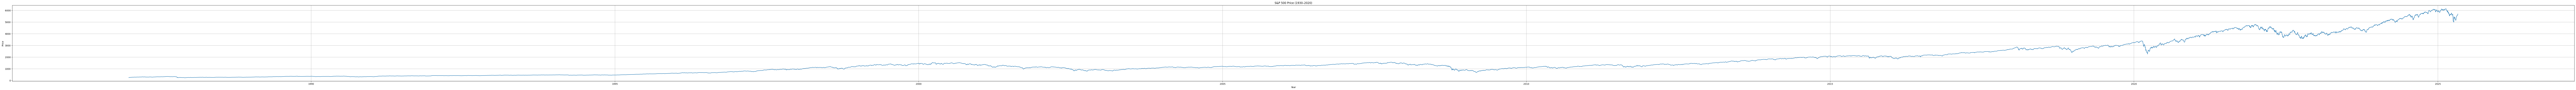

In [9]:
plt.figure(figsize=(200, 6))
plt.plot(df['date'], df['SP_price'])
plt.title('S&P 500 Price (1930–2020)')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)
plt.show()

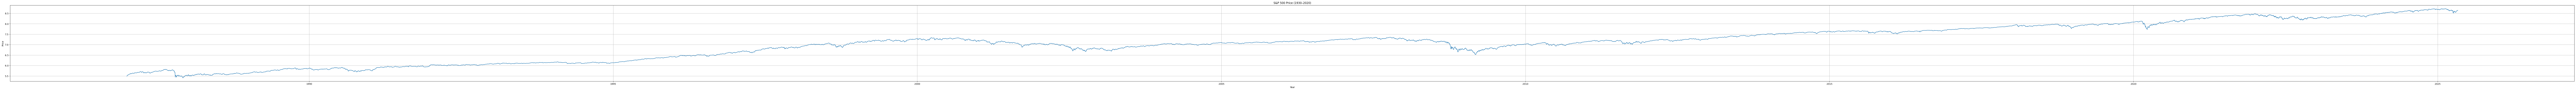

In [10]:
plt.figure(figsize=(200, 6))
plt.plot(df['date'], df['SP_price_ln'])
plt.title('S&P 500 Price (1930–2020)')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)
plt.show()

### Features we used are listed below

In [11]:
daily_features = ["SP_price_ln", "dow_jones_ln", "gdp_ln", "eur", "jpy", "home_price_index_ln", "consumer_price_index", "bond_yield_ln"]

# Change predictive range from here
#################
lookback = 60
forecast = 10
#################
new_cols = {}

for f in daily_features:
    new_cols[f + f"+{forecast}"] = df[f].shift(-forecast)

for f in daily_features:
    for i in range(1, lookback + 1):
        new_cols[f + f"-{i}"] = df[f].shift(i)

df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)

df_with_wknd = df.copy()
df = df[df['date'].dt.weekday < 5].reset_index(drop=True)
# i = 1
# for col in df.columns:
#     print(i, col)
#     i+=1
print(df.shape)
df.head(5)

(10002, 505)


,date,SP_price,dow_jones,gdp,bond_yield,home_price_index,consumer_price_index,eur,jpy,SP_MA_30,...,bond_yield_ln-51,bond_yield_ln-52,bond_yield_ln-53,bond_yield_ln-54,bond_yield_ln-55,bond_yield_ln-56,bond_yield_ln-57,bond_yield_ln-58,bond_yield_ln-59,bond_yield_ln-60
0,1987-01-01,242.712498,1895.95,4722.156,7.23,63.733,111.4,0.9107,157.47,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1987-01-02,244.309998,1927.31,4722.156,7.18,63.733,111.4,0.9084,158.02,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1987-01-05,249.415001,1971.32,4722.156,7.08,63.733,111.4,0.9149,159.13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1987-01-06,252.777500,1974.83,4722.156,7.08,63.733,111.4,0.9107,158.75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1987-01-07,254.119999,1993.95,4722.156,7.05,63.733,111.4,0.9162,157.75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


5. Data Analysis
    - We implemented a 2 level linear regression model.
    - Level 1 fits all features and selects which features have the highest correlation.
    - Level 2 uses those high-correlated features to make a more accurate prediction.
        - Values are first normalized for equal weights between the features.
        - We used adjusted R^2 as our optimization function, then use that to find which features have the highest R^2
        - Select the features (Greedy model). For each features, the model only keeps it if the addition of the feature improves the R^2


In [12]:
# level 1
df_filtered = df[(df['date'].dt.year >= 1980) & (df['date'].dt.year <= 2020)]
col =  df.iloc[:, 26:].columns
df_filtered = df_filtered.dropna(subset=col)
X = df_filtered[col]
y = df_filtered[f'SP_price_ln+{forecast}']

model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)


In [13]:
refined = []
for i in range(len(col)):
    if abs(model.coef_[i]) > 0.1:
        refined.append(col[i])


In [14]:
print(len(refined))

117


In [15]:
df_model2 = df[(df['date'].dt.year >= 1980) & (df['date'].dt.year <= 2020)]
features = df.iloc[:, 26:]

scaler_global = StandardScaler()
scaled_array = scaler_global.fit_transform(features)
normalized_all = pd.DataFrame(scaled_array, index=features.index, columns=features.columns)

n = len(normalized_all)

def adj_r2(R2, p):
    return 1 - (1 - R2) * (n - 1) / (n - p - 1)

# Your target columns
target_columns = [
    "SP_price_ln",
    # "dow_jones_ln",
    "eur",
    "jpy",
    # "consumer_price_index",
    "bond_yield_ln"
    # "gdp_ln"
]

models = {}

for y_col in target_columns:
    print(f"\n=== Building model for: {y_col} ===")
    y = df_model2[y_col]
    normalized = normalized_all.copy()
    normalized[y_col] = y

    mod_scores = []
    for c in normalized.columns:
        if c == y_col:
            continue
        model = LinearRegression(fit_intercept=True)
        working_df = normalized.dropna(subset=[y_col, c])
        col = working_df[c].to_numpy().reshape(-1, 1)
        model.fit(col, working_df[y_col])
        score = adj_r2(model.score(col, working_df[y_col]), 1)
        mod_scores.append((c, score))

    mod_scores = sorted(mod_scores, key=lambda x: x[1], reverse=True)

    best_score = 0
    selected_cols = []
    reg = LinearRegression(fit_intercept=True)

    for c, _ in mod_scores:
        working_df = normalized.dropna(subset=selected_cols + [c, y_col])
        X = working_df[selected_cols + [c]]
        reg.fit(X, working_df[y_col])
        score = adj_r2(reg.score(X, working_df[y_col]), len(selected_cols) + 1)
        if score > best_score:
            best_score = score
            selected_cols += [c]

    # Final fit with scaler
    final_scaler = StandardScaler()
    working_df = df_model2.dropna(subset=selected_cols + [y_col])
    X_raw = working_df[selected_cols]
    X_scaled = pd.DataFrame(final_scaler.fit_transform(X_raw), columns=selected_cols)
    X_scaled.index = working_df.index
    reg.fit(X_scaled, working_df[y_col])

    # Statsmodels OLS summary
    X_scaled_with_const = sm.add_constant(X_scaled)
    sm_model = sm.OLS(working_df[y_col], X_scaled_with_const).fit()
    print(sm_model.summary())

    # Save everything
    models[y_col] = {
        'features': selected_cols,
        'scaler': final_scaler,
        'reg': reg,
        'sm_model': sm_model
    }



=== Building model for: SP_price_ln ===
                            OLS Regression Results                            
Dep. Variable:            SP_price_ln   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.302e+06
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        10:32:29   Log-Likelihood:                 30747.
No. Observations:                8858   AIC:                        -6.138e+04
Df Residuals:                    8800   BIC:                        -6.097e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

6. Modeling, Testing and Visualization
   - Below is a method that tests a specific date and pprojects the prediction onto a graph along with the actual data
   - The method creates a price prediction for each of the prediction range (day 1 to 15), and graphs it to show a continous prediction

In [16]:
def plot_predictions(selected_date, window=30):
    selected_date = pd.to_datetime(selected_date)
    selected_idx = df[df['date'] == selected_date].index[0]

    predicted_series = {target: [] for target in models.keys()}
    predicted_dates = []

    current_row = df.iloc[selected_idx].copy()

    for step in range(forecast):
        idx = selected_idx + step
        predicted_dates.append(df['date'].iloc[idx])

        # Iterate over each model to predict and update
        for target_var, model_data in models.items():
            features = model_data['features']
            scaler = model_data['scaler']
            reg = model_data['reg']

            # Prepare features for prediction
            X_features = current_row[features]
            X_scaled = pd.DataFrame(scaler.transform(X_features.to_frame().T), columns=features)

            pred_ln = reg.predict(X_scaled)[0]
            predicted_series[target_var].append(pred_ln)

            # Find lagged columns for this target (e.g., SP_price_ln_t-1)
            lagged_cols = [col for col in features if target_var in col]
            if lagged_cols:
                shifted_vals = current_row[lagged_cols].copy()
                shifted_vals = [pred_ln] + list(shifted_vals.values[:-1])
                current_row[lagged_cols] = shifted_vals

        # No need to handle valid_indices if dates are aligned

    # Plot SP500 as the main example
    plot_start = selected_idx - window
    plot_end = selected_idx + forecast + window

    plt.figure(figsize=(16, 6))
    plt.plot(df.index[plot_start:plot_end], df['SP_price'].iloc[plot_start:plot_end],
             label='Actual SP500', linewidth=4, color='blue')
    plt.plot(range(selected_idx, selected_idx + forecast),
             np.exp(predicted_series['SP_price_ln']), 'ro--',
             label=f'Iterative SP500 prediction ({forecast} days)', linewidth=3, markersize=8)

    plt.axvline(x=selected_idx, color='green', linewidth=3)

    xticks = df.index[plot_start:plot_end:5]
    xlabels = df['date'].iloc[plot_start:plot_end:5].dt.strftime('%Y-%m-%d')
    plt.xticks(ticks=xticks, labels=xlabels, rotation=45)

    plt.title(f"Iterative {forecast}-day prediction from {selected_date.date()}")
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.legend()
    plt.show()

    # Error metric for SP500
    actual_prices = df['SP_price'].iloc[selected_idx:selected_idx + forecast].values
    predicted_prices = np.array(predicted_series['SP_price_ln']).flatten()

    mse = mean_squared_error(actual_prices, predicted_prices)
    rmse = np.sqrt(mse)
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')

    # Optional: print other series' last predicted values
    for target_var, preds in predicted_series.items():
        print(f"Last predicted {target_var}: {preds[-1]}")


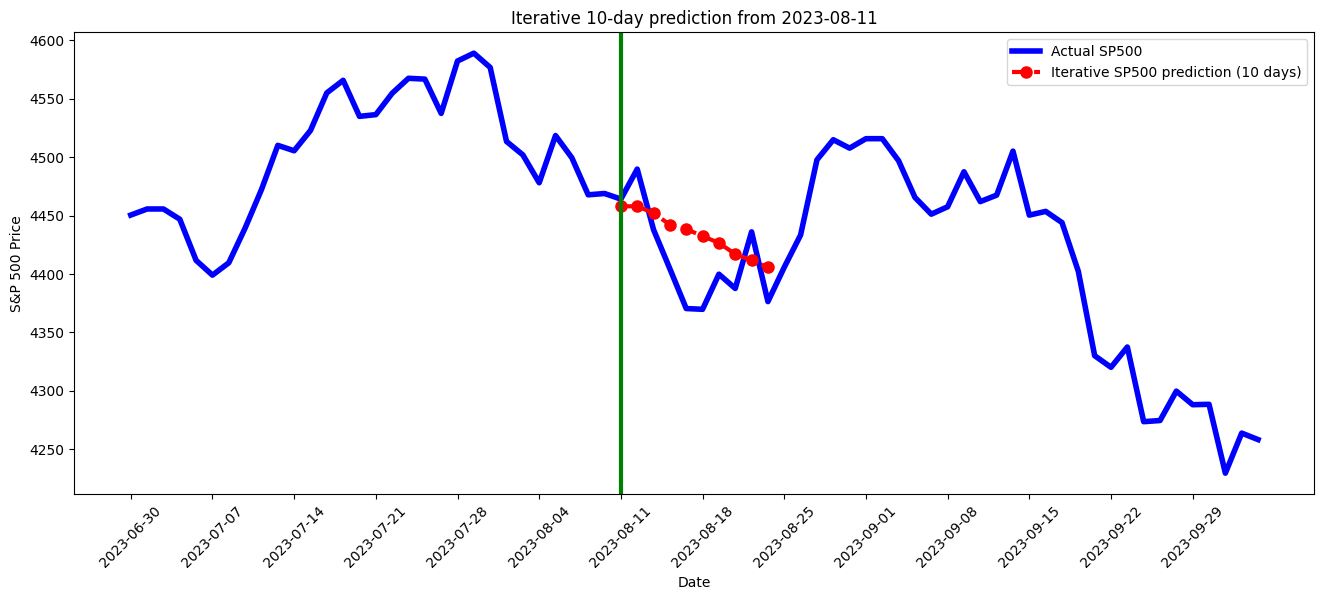

Mean Squared Error: 19407079.06934609
Root Mean Squared Error: 4405.346645764223
Last predicted SP_price_ln: 8.39066596302818
Last predicted eur: 0.9146121173580156
Last predicted jpy: 144.01803034264327
Last predicted bond_yield_ln: 1.3704497352974798


In [17]:
plot_predictions('2023-8-11')

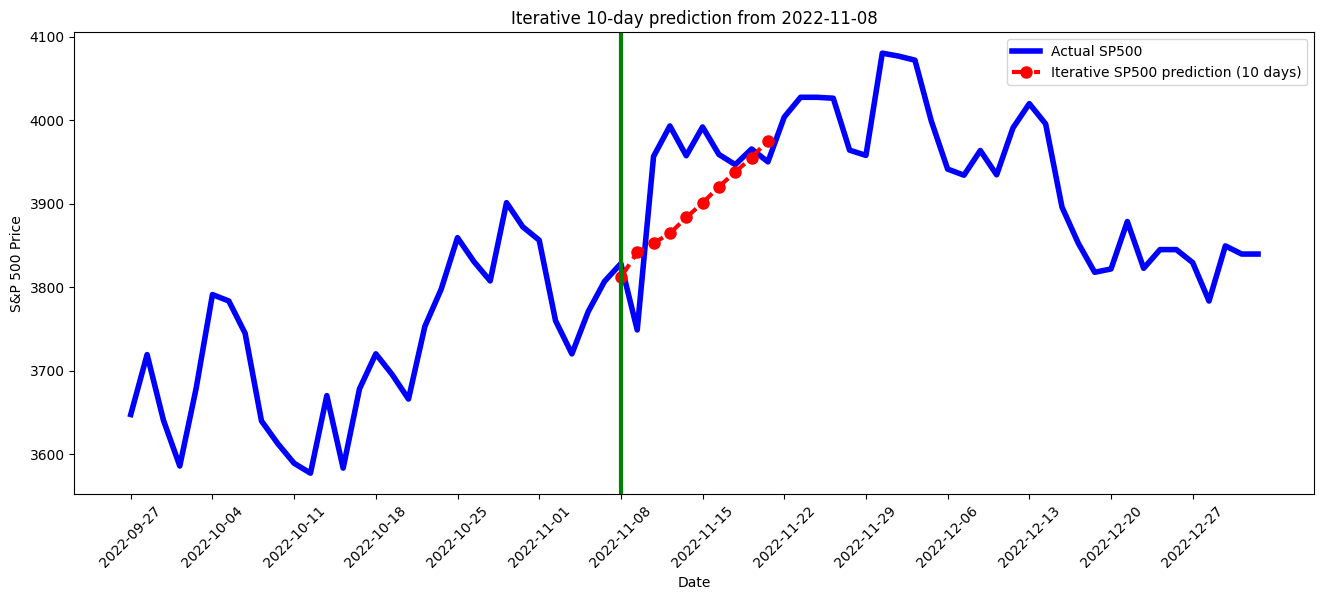

Mean Squared Error: 15382054.1573459
Root Mean Squared Error: 3921.9961954782543
Last predicted SP_price_ln: 8.287859803623173
Last predicted eur: 0.992523461363265
Last predicted jpy: 144.7650264024307
Last predicted bond_yield_ln: 1.3882954144487991


In [18]:
plot_predictions('2022-11-8')

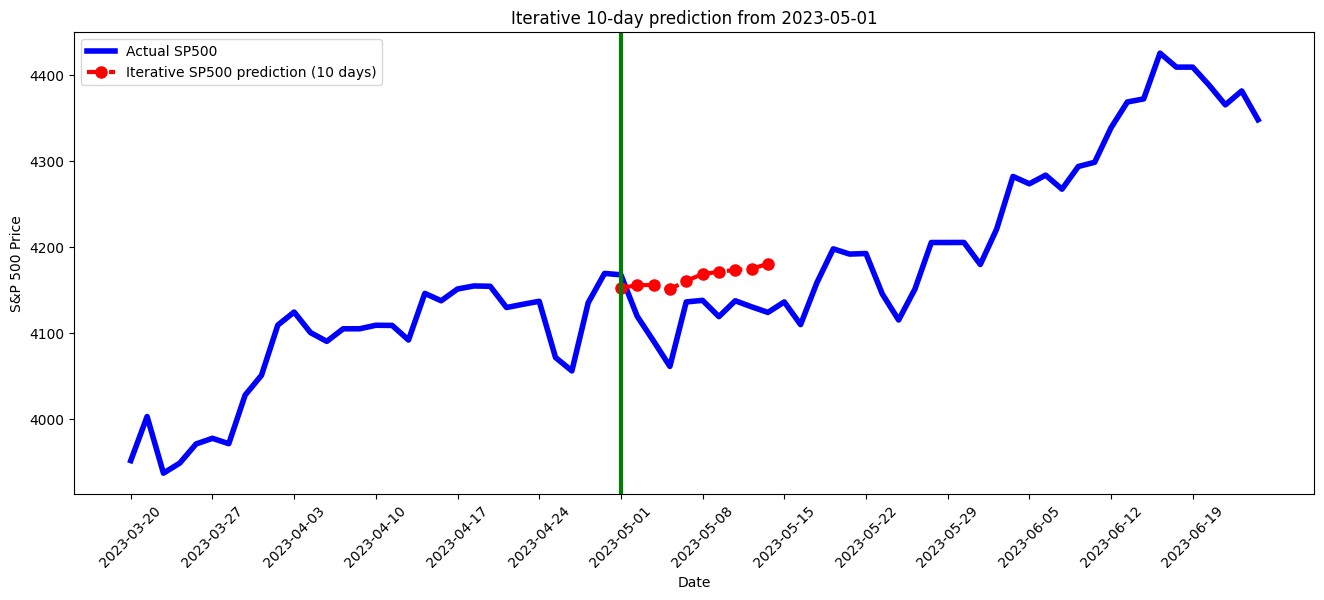

Mean Squared Error: 16927362.92587582
Root Mean Squared Error: 4114.287657162029
Last predicted SP_price_ln: 8.338170351271664
Last predicted eur: 0.9220841858823422
Last predicted jpy: 135.42284101138273
Last predicted bond_yield_ln: 1.132110562588913


In [19]:
plot_predictions('2023-5-1')

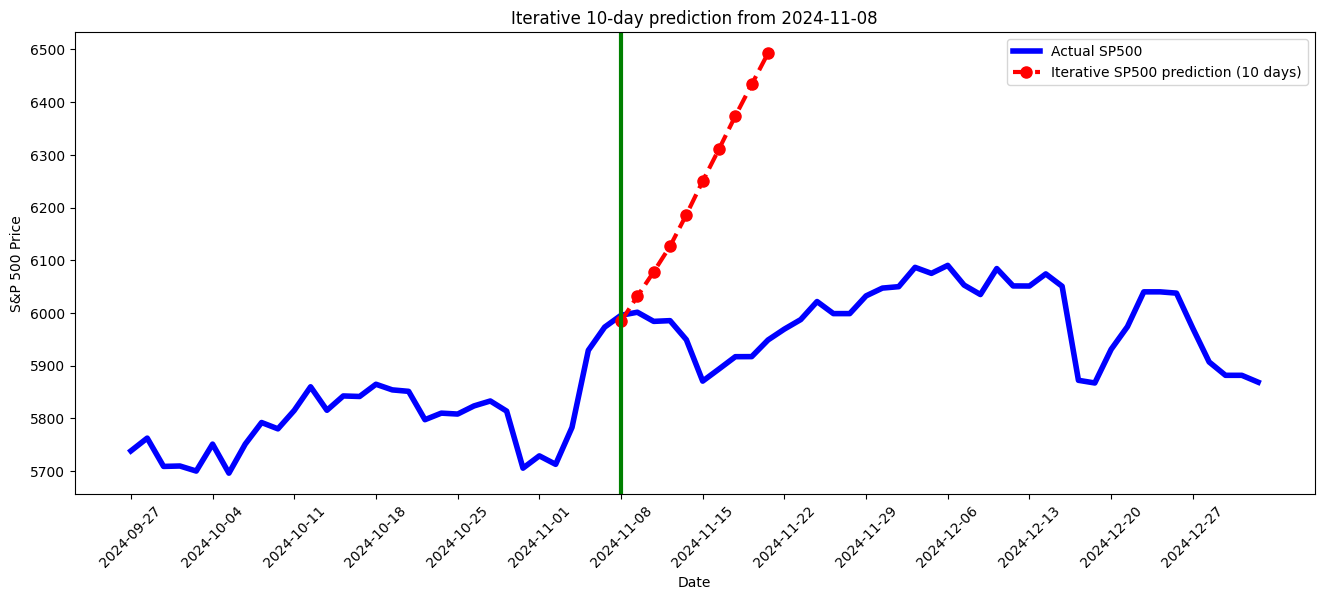

Mean Squared Error: 35255898.37652216
Root Mean Squared Error: 5937.667755653069
Last predicted SP_price_ln: 8.778475155386294
Last predicted eur: 0.9156160561124536
Last predicted jpy: 151.0726204579871
Last predicted bond_yield_ln: 1.3651866309645666


In [20]:
plot_predictions('2024-11-8')

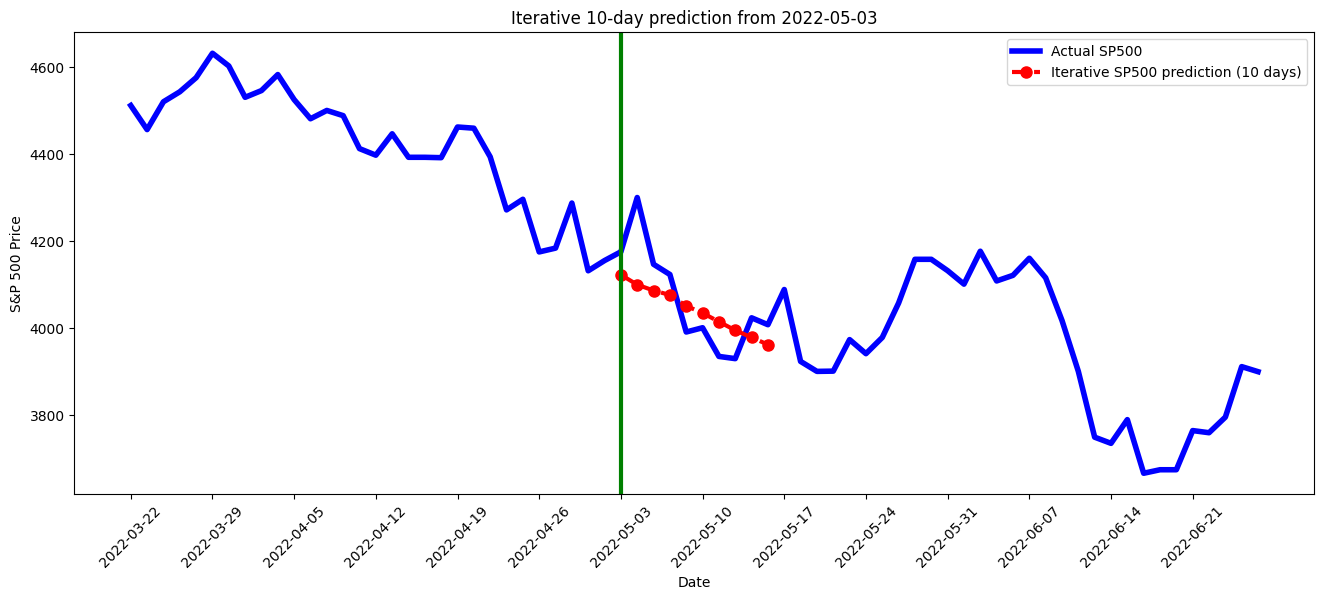

Mean Squared Error: 16457571.887869578
Root Mean Squared Error: 4056.7933011024334
Last predicted SP_price_ln: 8.284594949979425
Last predicted eur: 0.94181774642274
Last predicted jpy: 129.7897575224194
Last predicted bond_yield_ln: 1.0650315373459878


In [21]:
plot_predictions('2022-5-3')

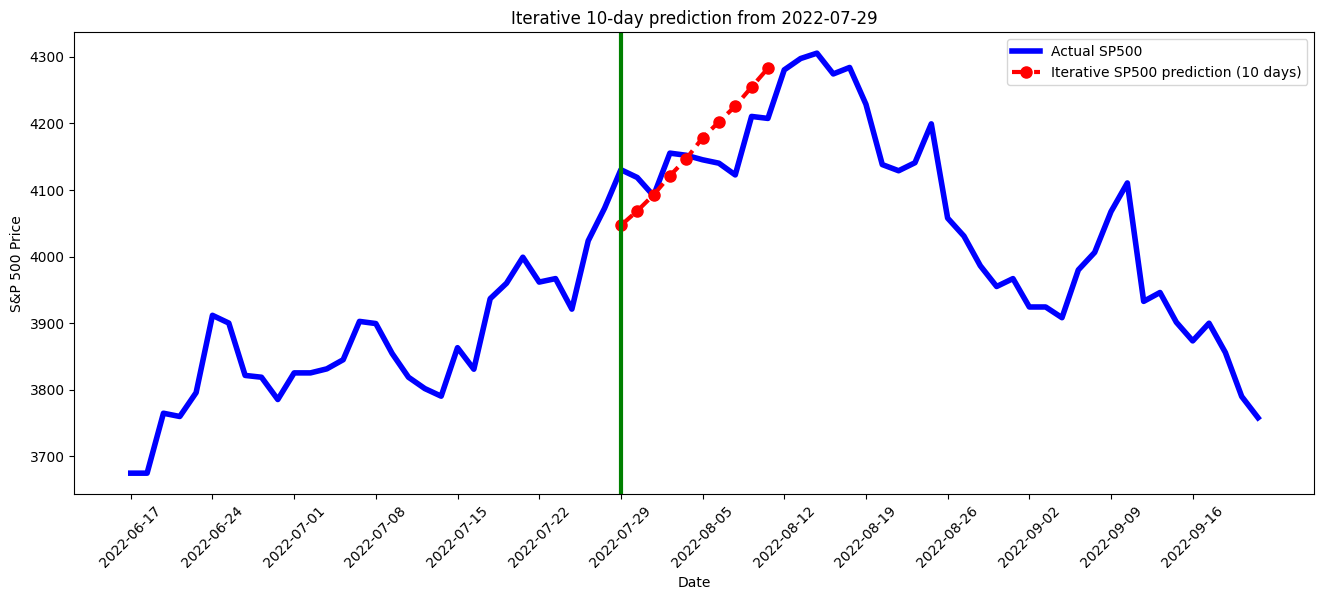

Mean Squared Error: 17131844.53576998
Root Mean Squared Error: 4139.063243750931
Last predicted SP_price_ln: 8.362311036730917
Last predicted eur: 0.9751662070710954
Last predicted jpy: 132.80202448269202
Last predicted bond_yield_ln: 0.8906492808294623


In [22]:
plot_predictions('2022-7-29')

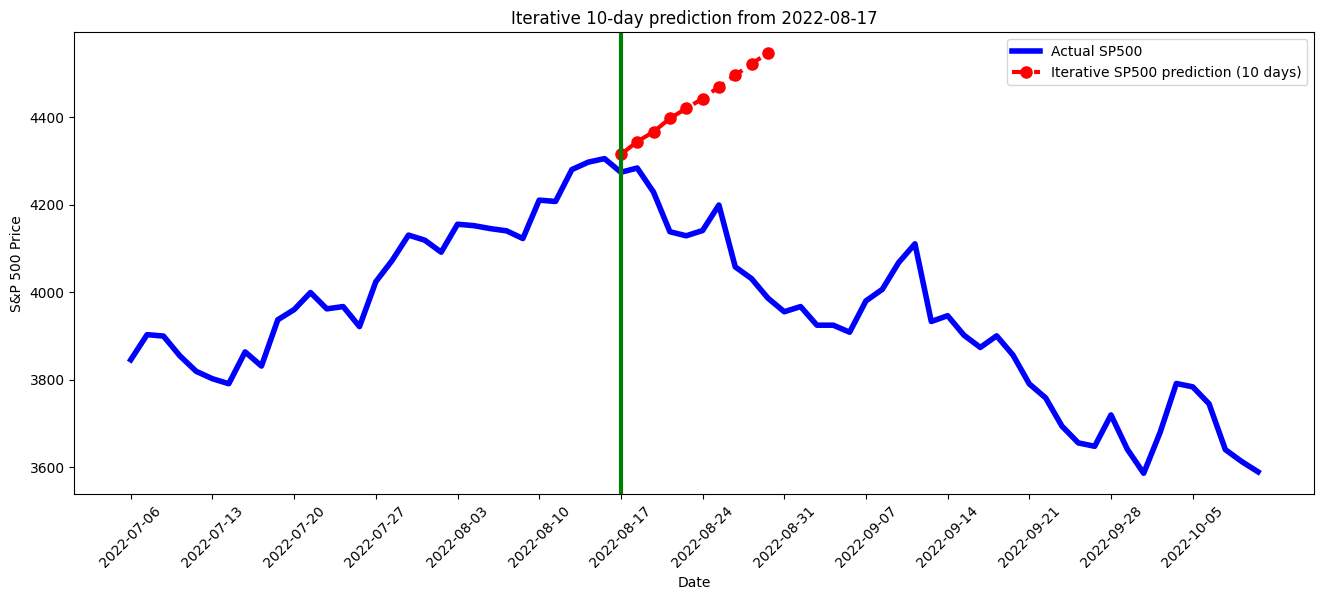

Mean Squared Error: 17135011.780336298
Root Mean Squared Error: 4139.445830100485
Last predicted SP_price_ln: 8.422049959151845
Last predicted eur: 0.974719983779826
Last predicted jpy: 133.04754764939827
Last predicted bond_yield_ln: 0.9299690338916438


In [23]:
plot_predictions('2022-8-17')

In [24]:
forecast = 10
def plot_all_predictions(selected_date, window=15):
    selected_date = pd.to_datetime(selected_date)
    selected_idx = df[df['date'] == selected_date].index[0]

    # Store predictions + confidence intervals
    predicted_series = {
        target: {'preds': [], 'lower': [], 'upper': []}
        for target in models.keys()
    }
    predicted_dates = []

    current_row = df.iloc[selected_idx].copy()

    for step in range(forecast):
        idx = selected_idx + step
        predicted_dates.append(df['date'].iloc[idx])

        # Predict each target and update lagged features
        for target_var, model_data in models.items():
            features = model_data['features']
            scaler = model_data['scaler']
            reg = model_data['reg']
            sm_model = model_data['sm_model']

            # Prepare features for prediction
            X_features = current_row[features]
            X_scaled = pd.DataFrame(scaler.transform(X_features.to_frame().T), columns=features)

            # Match exact columns from training (avoid constant mismatch)
            X_scaled_with_const = pd.DataFrame(
                sm.add_constant(X_scaled, has_constant='add'),
                columns=sm_model.model.exog_names
            )

            pred = sm_model.get_prediction(X_scaled_with_const)
            pred_summary = pred.summary_frame(alpha=0.05)

            pred_value = pred_summary['mean'].iloc[0]
            lower_bound = pred_summary['obs_ci_lower'].iloc[0]
            upper_bound = pred_summary['obs_ci_upper'].iloc[0]

            # Store
            predicted_series[target_var]['preds'].append(pred_value)
            predicted_series[target_var]['lower'].append(lower_bound)
            predicted_series[target_var]['upper'].append(upper_bound)

            # Update lagged columns if applicable
            lagged_cols = [col for col in features if target_var in col]
            if lagged_cols:
                shifted_vals = current_row[lagged_cols].copy()
                shifted_vals = [pred_value] + list(shifted_vals.values[:-1])
                current_row[lagged_cols] = shifted_vals

    # Plotting
    num_targets = len(models)
    fig, axes = plt.subplots(num_targets, 1, figsize=(10, 4 * num_targets), sharex=True)

    if num_targets == 1:
        axes = [axes]  # Make iterable if only one

    plot_start = selected_idx - 35
    plot_end = selected_idx + forecast + 10
    x_range = df.index[plot_start:plot_end]
    xticks = df.index[plot_start:plot_end:5]
    xlabels = df['date'].iloc[plot_start:plot_end:5].dt.strftime('%Y-%m-%d')

    for ax, (target_var, series_data) in zip(axes, predicted_series.items()):
        # Clean name (remove '_ln')
        clean_name = target_var.replace('_ln', '')

        # Actual series (possibly exp)
        actual_series = df[target_var].iloc[plot_start:plot_end]
        if target_var.endswith('_ln'):
            actual_series = np.exp(actual_series)
            preds = np.exp(series_data['preds'])
            lower = np.exp(series_data['lower'])
            upper = np.exp(series_data['upper'])
        else:
            preds = series_data['preds']
            lower = series_data['lower']
            upper = series_data['upper']

        forecast_idx_range = range(selected_idx, selected_idx + forecast)

        ax.plot(x_range, actual_series,
                label=f'Actual {clean_name}', linewidth=3, color='blue')

        ax.plot(forecast_idx_range, preds,
                'ro--', label=f'Predicted {clean_name}', linewidth=3, markersize=6)

        # Add confidence interval as shaded area
        # ax.fill_between(forecast_idx_range, lower, upper,
        #                 color='gray', alpha=0.4, label='95% Prediction Interval')

        ax.axvline(x=selected_idx-1, color='green', linewidth=3)
        ax.set_title(f'{clean_name} prediction')
        ax.legend()
        
        ax.axvspan(idx-30, idx-1, color="gray", alpha=0.3)

    # Set shared x-ticks & labels at the end (global)
    plt.xticks(ticks=xticks, labels=xlabels, rotation=45)
    plt.tight_layout()
    plt.show()



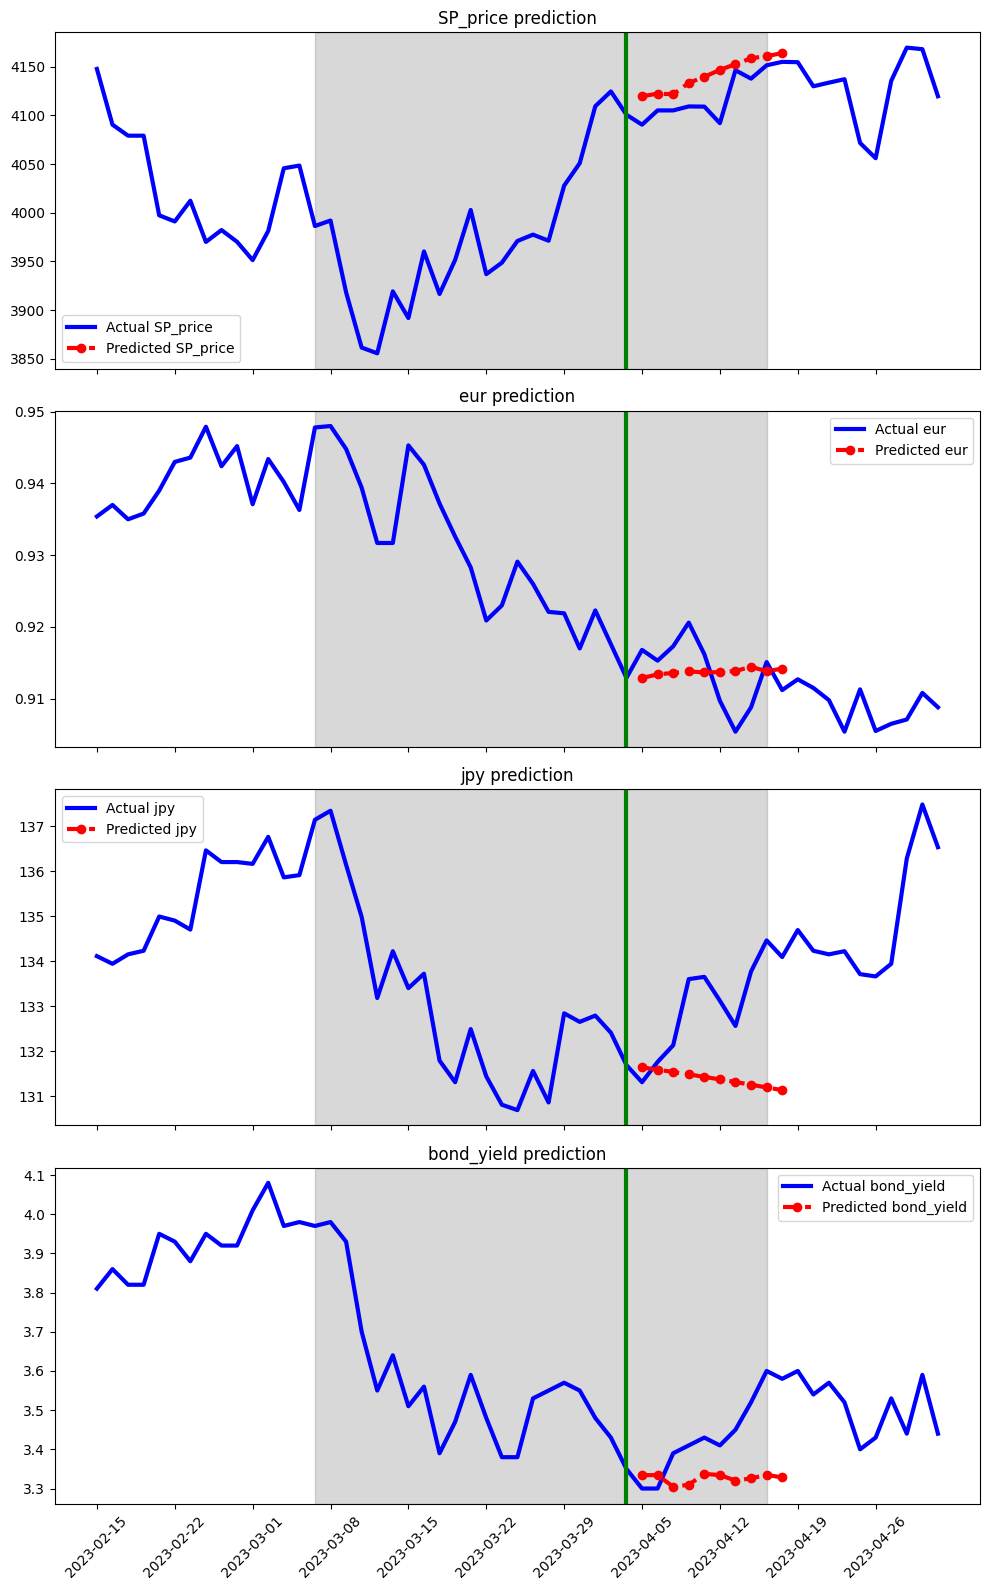

In [25]:
plot_all_predictions('2023-4-5')

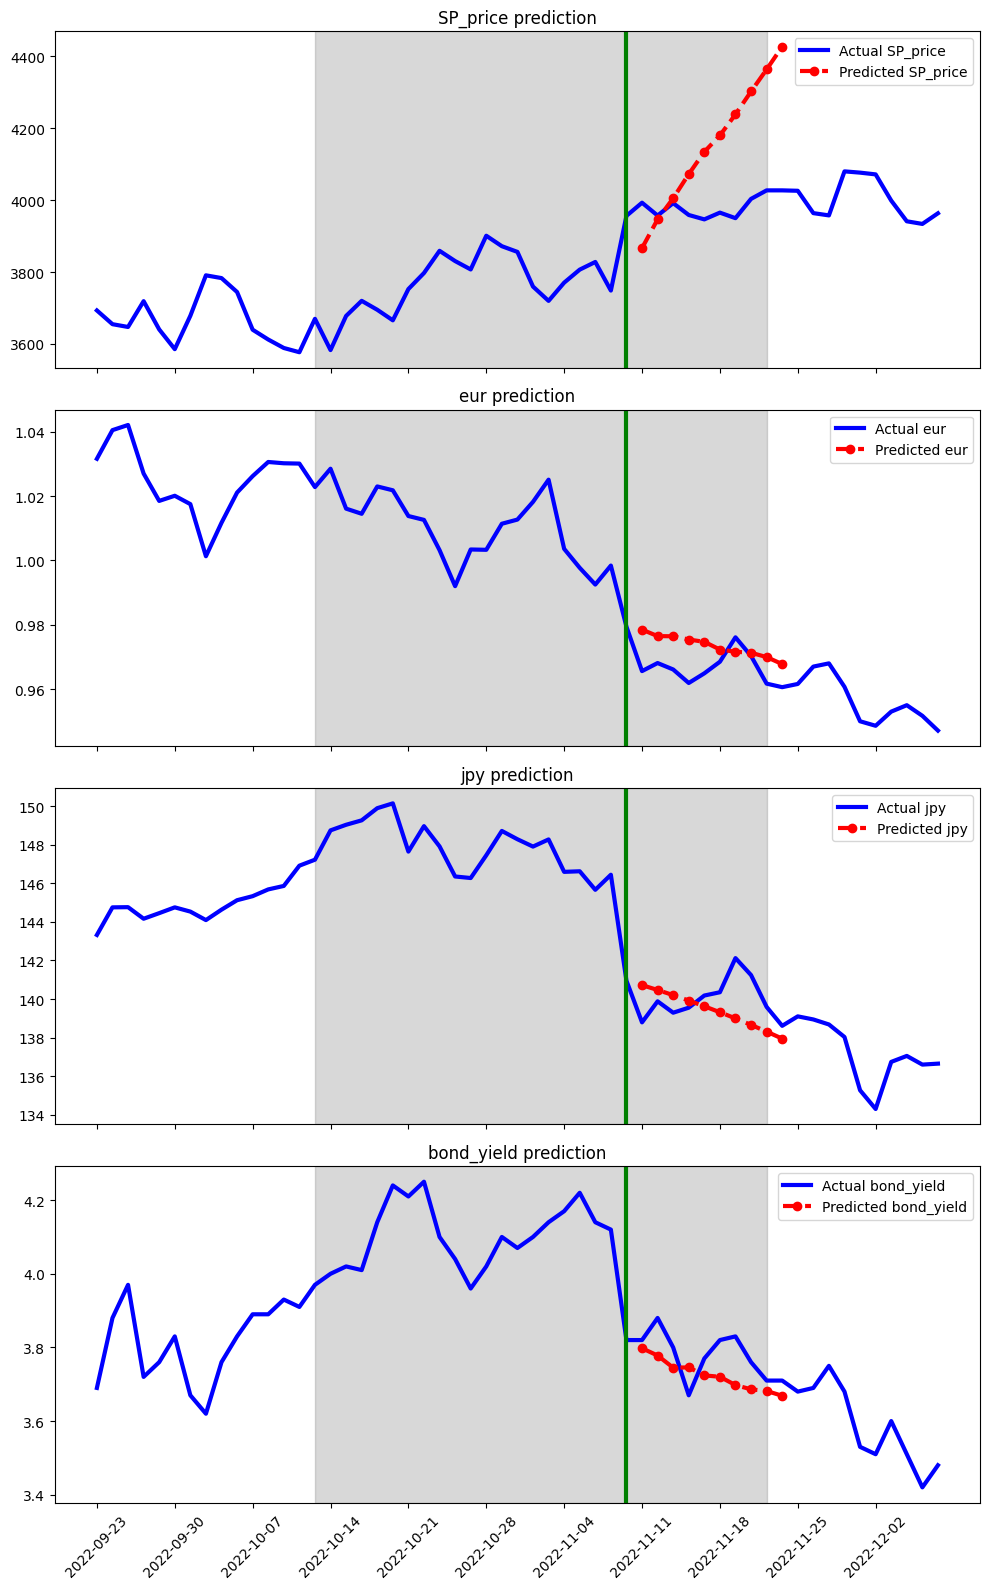

In [26]:

plot_all_predictions('2022-11-11')

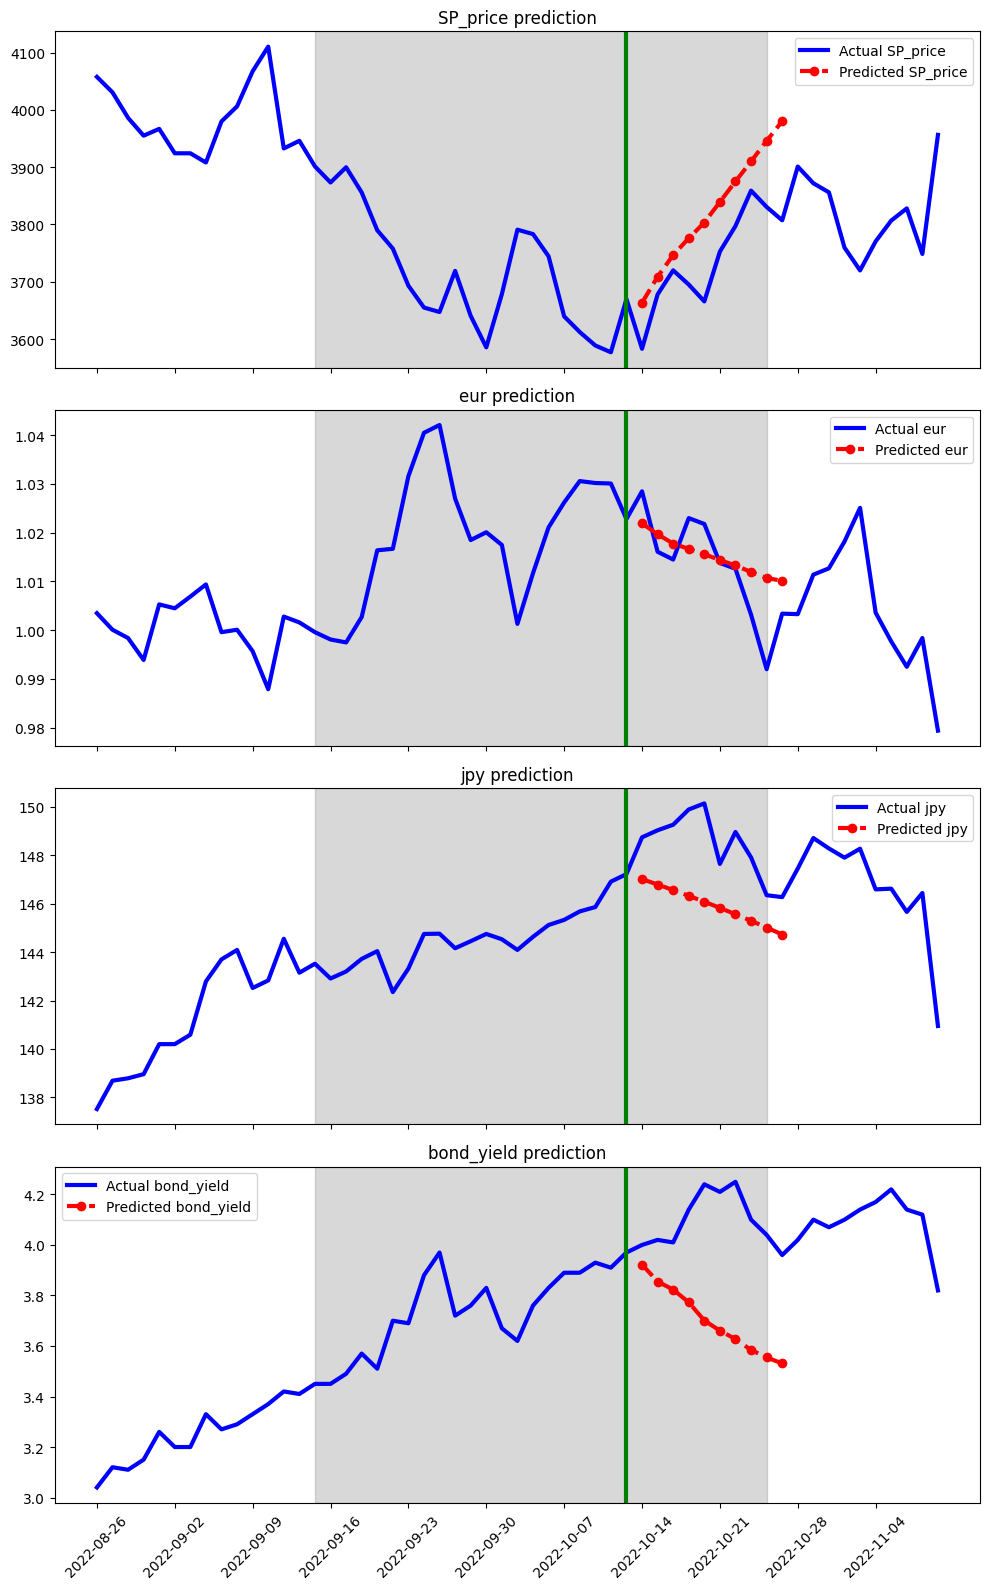

In [27]:
plot_all_predictions('2022-10-14')

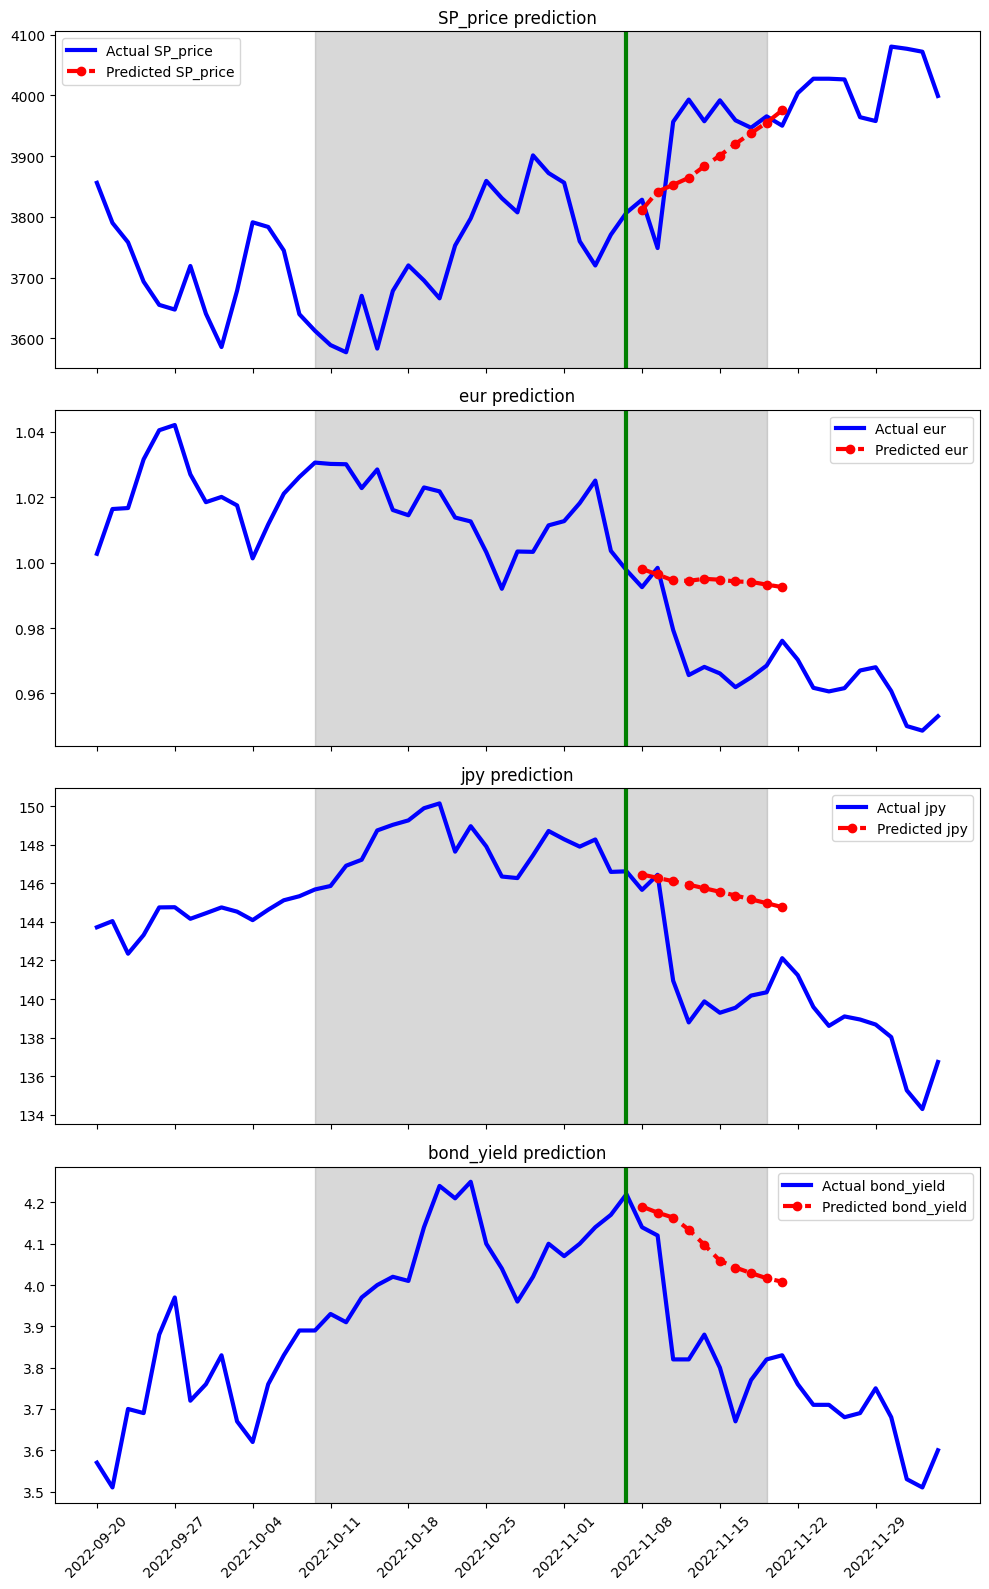

In [28]:
plot_all_predictions('2022-11-8')

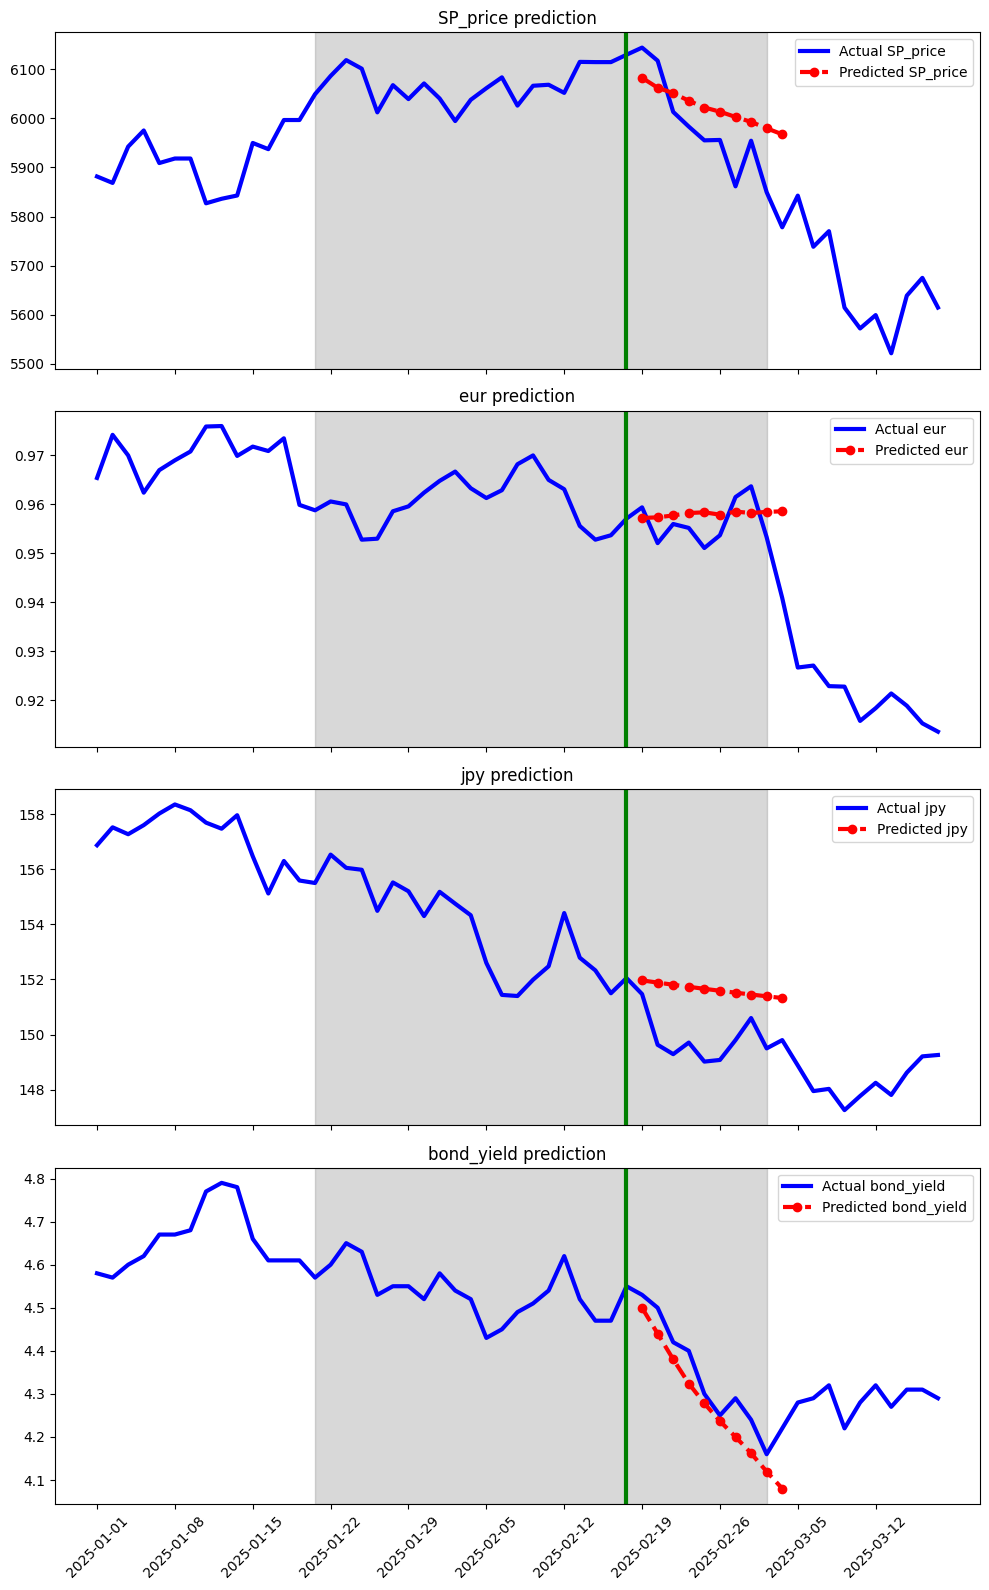

In [29]:
#### pretty good
plot_all_predictions('2025-2-19')

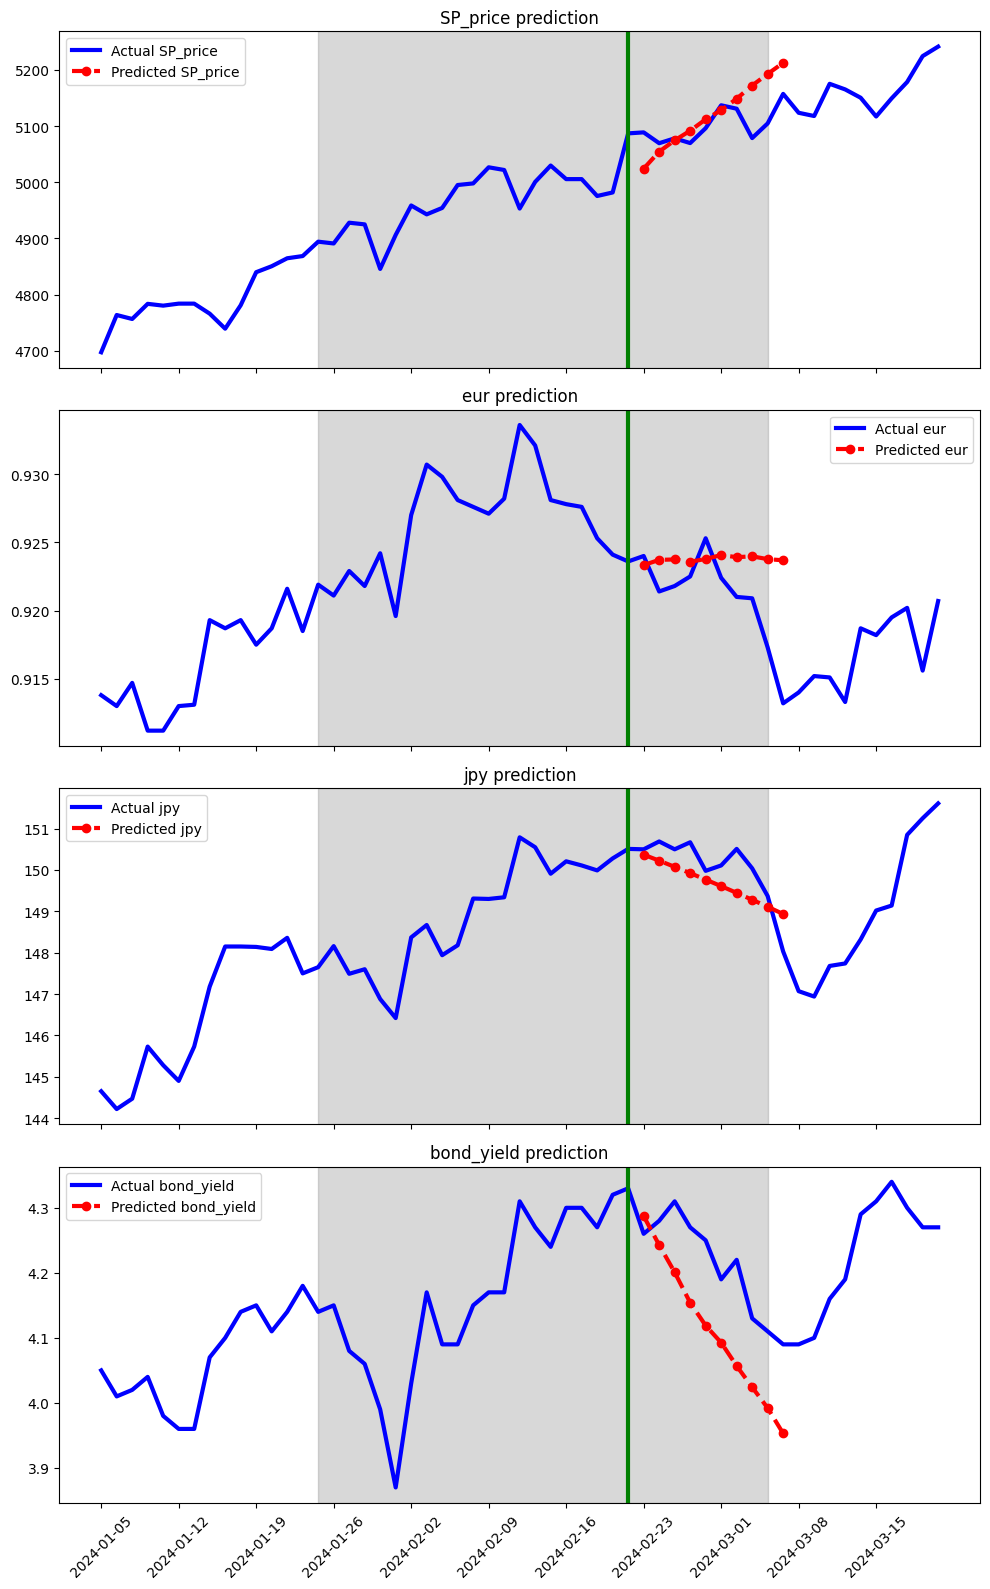

In [30]:
plot_all_predictions('2024-2-23')

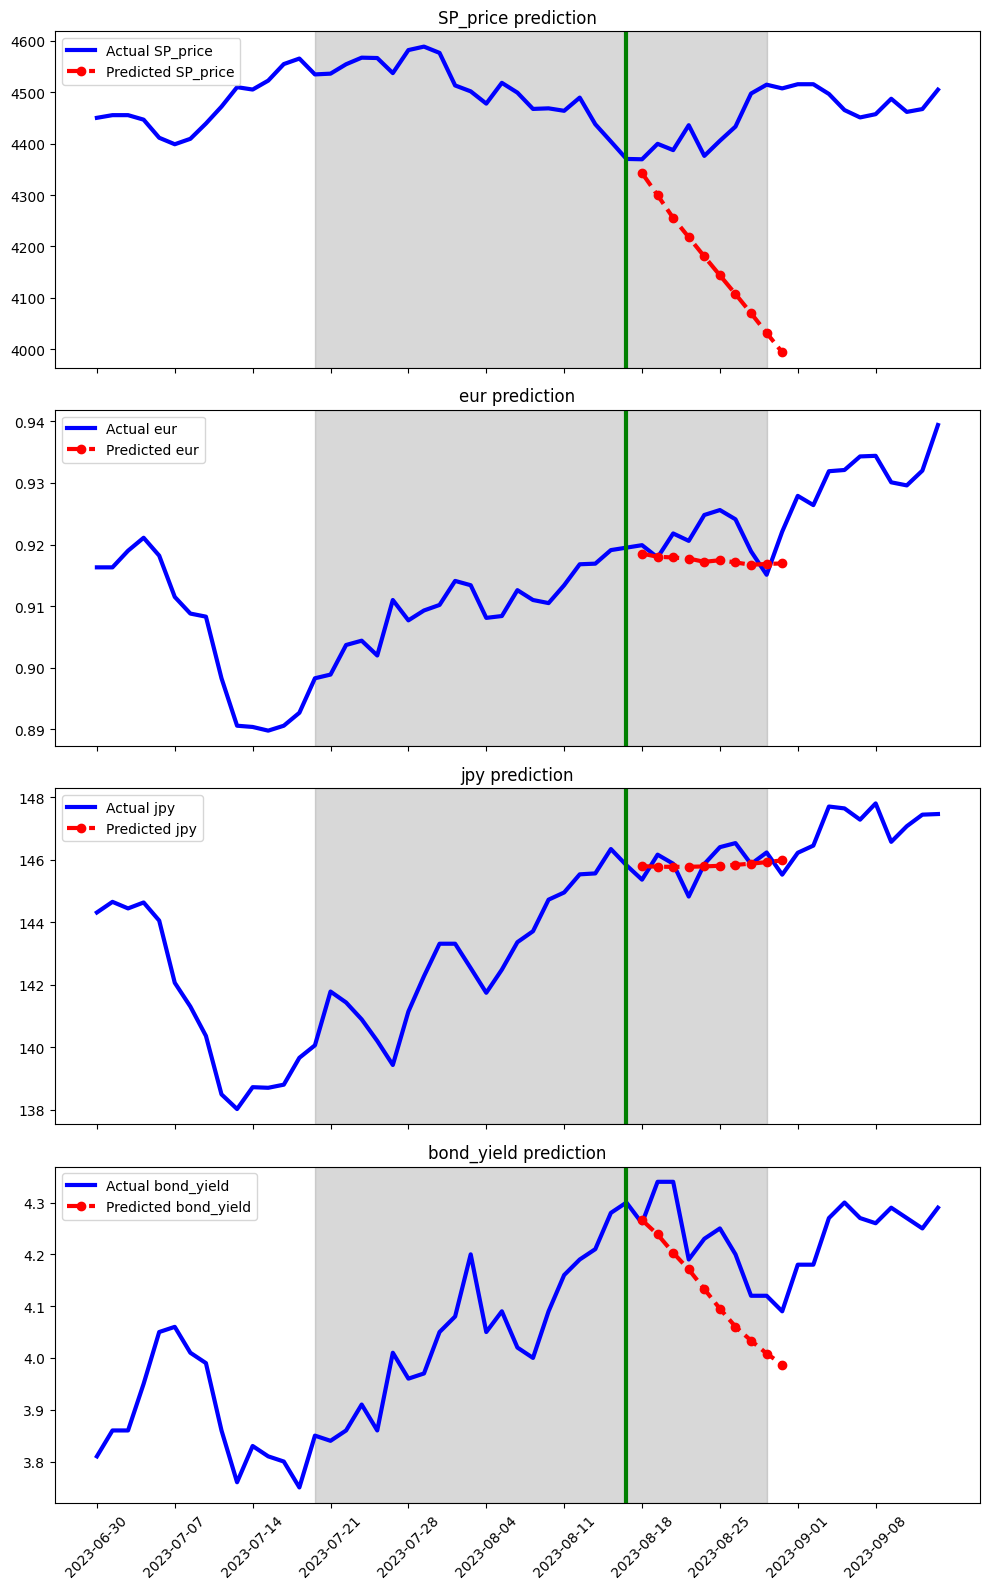

In [31]:
## good example for bad fitting
plot_all_predictions('2023-8-18')

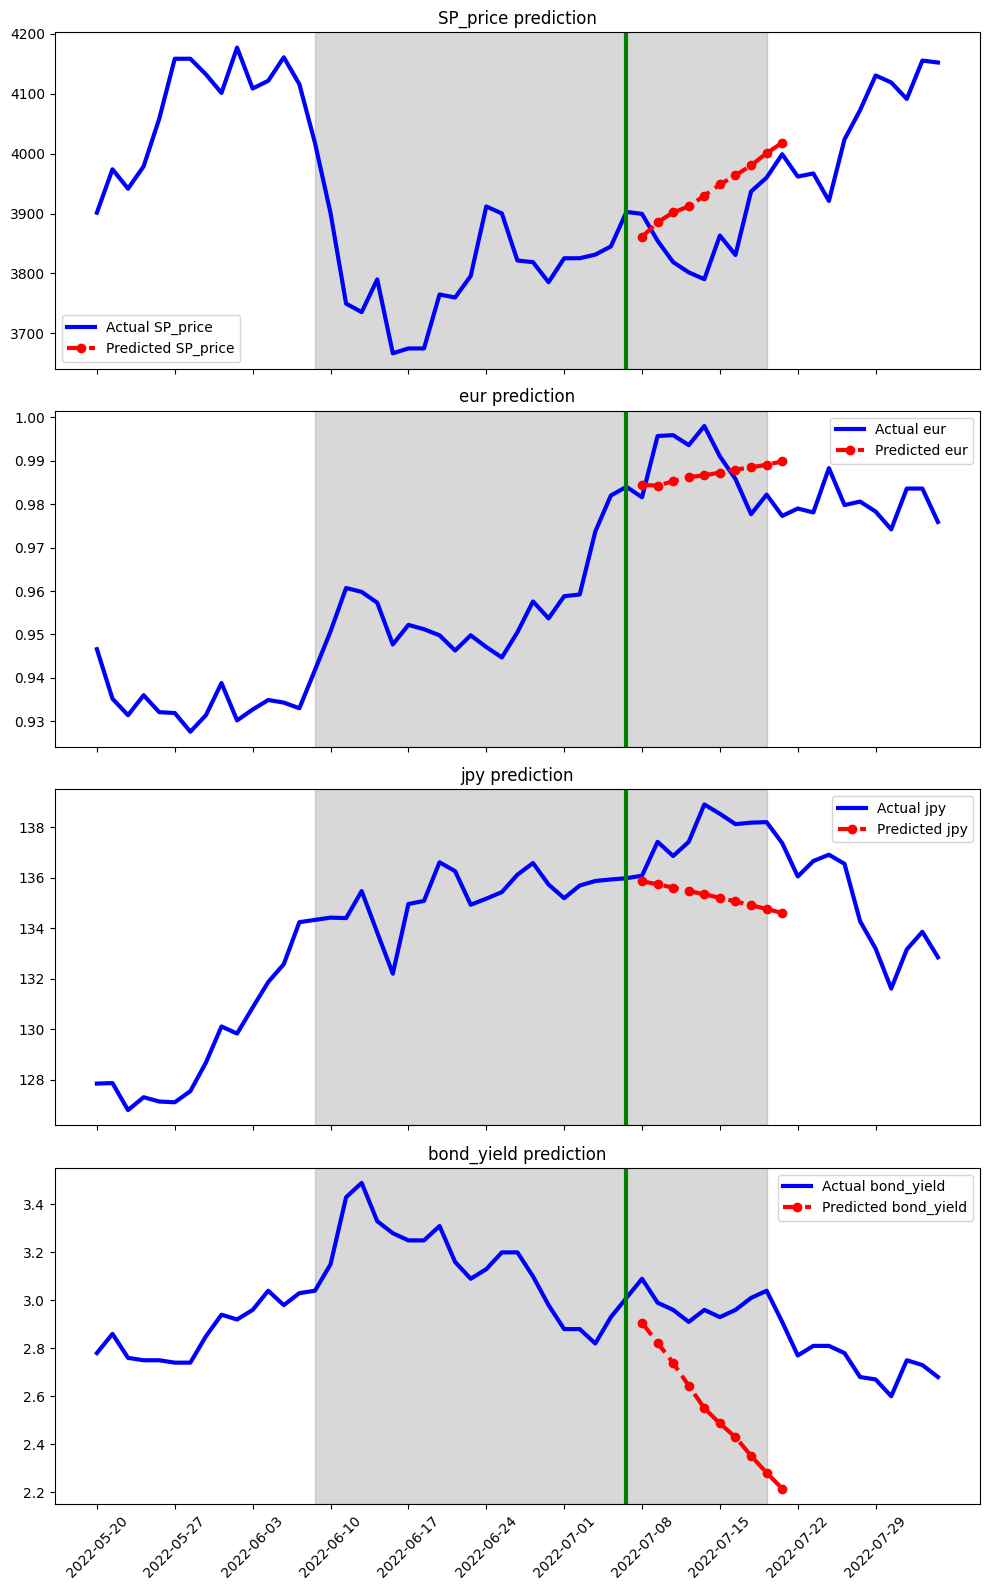

In [32]:
##### good example for good modeling
plot_all_predictions('2022-7-8')

In [33]:
# level 3
new_cols = {}
df_model3 = df[(df['date'].dt.year >= 1980) & (df['date'].dt.year <= 2020)]
for i in range(forecast):
    new_cols[f'SP_price_ln+{i}'] = df_model3['SP_price_ln'].shift(-i)
df_model3 = pd.concat([df_model3, pd.DataFrame(new_cols)], axis=1)

normalized = df_model3.copy()
scaler = StandardScaler()
y_col = [f'SP_price_ln+{i}' for i in range(forecast)]

y = df_model3[y_col]

In [34]:
scaled_array = scaler.fit_transform(features)
normalized = pd.DataFrame(scaled_array, index=features.index, columns=features.columns)
normalized[y_col] = y

n = len(normalized)
def adj_r2(R2, p):
    return 1 - (1-R2) * (n-1) / (n-p-1)

mod_3_scores = []
for c in normalized.columns:
    if c in y_col: continue
    model = LinearRegression(fit_intercept=True)
    working_df = normalized.dropna(subset=y_col + [c])
    col = working_df[c].to_numpy().reshape(-1, 1)
    model.fit(col, working_df[y_col])
    score = adj_r2(model.score(col, working_df[y_col]), 1)
    mod_3_scores.append((c, score))

mod_3_scores = sorted(mod_3_scores, key=lambda x: x[1], reverse=True)

mod_3_score = 0
mod_3_cols = []
reg3 = LinearRegression(fit_intercept=True)
for c, _ in mod_3_scores:
    working_df = normalized.dropna(subset=mod_3_cols + y_col + [c])
    X = working_df[mod_3_cols + [c]]
    reg3.fit(X, working_df[y_col])
    score = adj_r2(reg3.score(X, working_df[y_col]), len(mod_3_cols) + 1)
    if score > mod_3_score:
        mod_3_score = score
        mod_3_cols += [c]

final_scaler = StandardScaler()
working_df = df_model3.dropna(subset=mod_3_cols + y_col)
X3_raw = working_df[mod_3_cols]
X3_scaled = pd.DataFrame(final_scaler.fit_transform(X3_raw), columns=mod_3_cols)
X3_scaled.index = working_df.index

reg3.fit(X3_scaled, working_df[y_col])

LinearRegression()

In [35]:
def plot_predictions2(selected_date, window=30):
    selected_date = pd.to_datetime(selected_date)
    selected_idx = df[df['date'] == selected_date].index[0]

    # Extract current feature row and scale it
    current_row = df.iloc[selected_idx]
    X_features = current_row[mod_3_cols].to_frame().T  # shape: (1, n_features)
    X_scaled = pd.DataFrame(final_scaler.transform(X_features), columns=mod_3_cols)

    # Predict the entire window of log prices
    pred_ln_vector = reg3.predict(X_scaled)[0]
    predicted_prices = np.exp(pred_ln_vector)  # Convert log-prices to prices

    # Determine the corresponding future dates
    predicted_dates = df['date'].iloc[selected_idx:selected_idx + forecast].values

    # Plotting
    plot_start = selected_idx - window
    plot_end = selected_idx + forecast + window

    plt.figure(figsize=(16, 6))
    
    plt.plot(df.index[plot_start:plot_end], df['SP_price'].iloc[plot_start:plot_end],
             label='Actual price', linewidth=4, color='blue')
    plt.plot(range(selected_idx, selected_idx + forecast), predicted_prices,
             'ro--', label=f'Vector prediction ({forecast} days)', linewidth=3, markersize=8)
    plt.axvline(x=selected_idx, color='green', linewidth=3)

    xticks = df.index[plot_start:plot_end:5]
    xlabels = df['date'].iloc[plot_start:plot_end:5].dt.strftime('%Y-%m-%d')
    plt.xticks(ticks=xticks, labels=xlabels, rotation=45)
    
    plt.title(f"Vector {forecast}-day prediction from {selected_date.date()}")
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.legend()
    plt.show()

    # Error metrics if possible
    actual_prices = df['SP_price'].iloc[selected_idx:selected_idx + forecast].values
    mse = mean_squared_error(actual_prices, predicted_prices)
    rmse = np.sqrt(mse)
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')

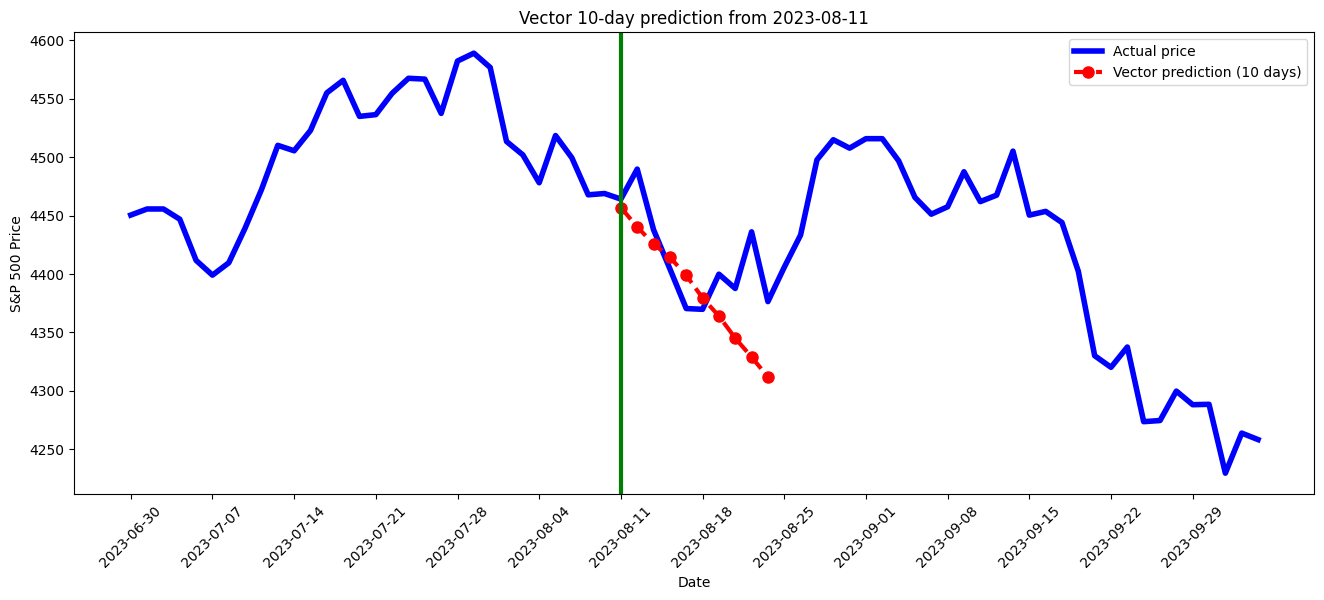

Mean Squared Error: 2238.8527
Root Mean Squared Error: 47.3165


In [36]:
plot_predictions2('2023-8-11')

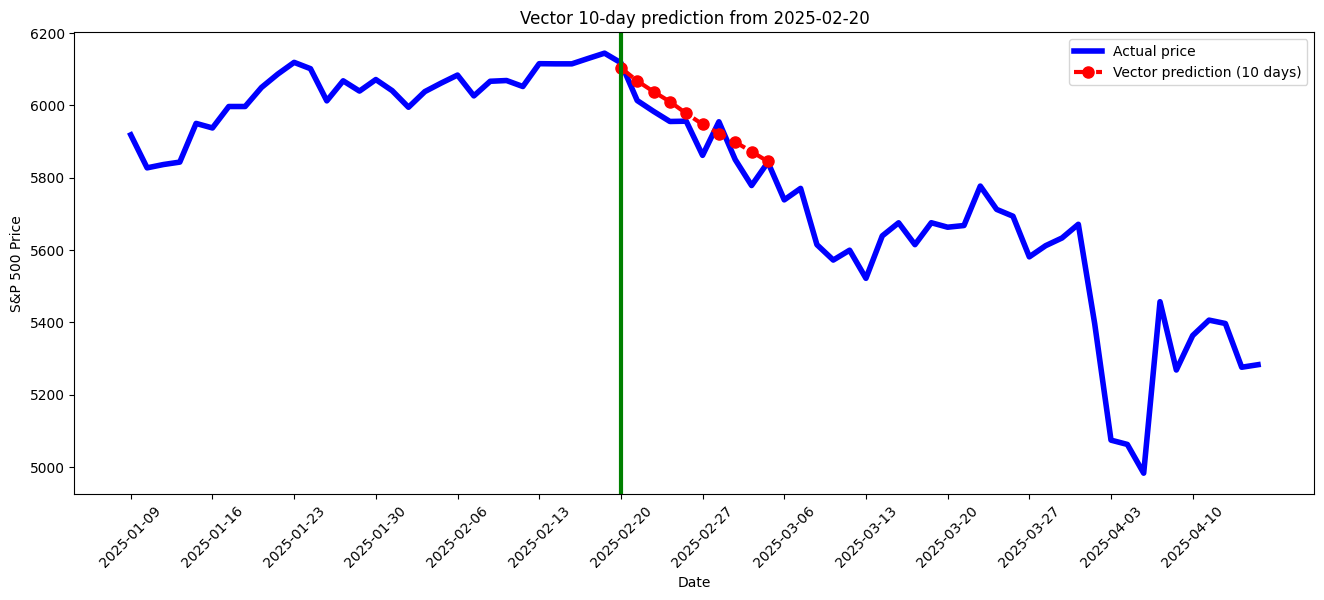

Mean Squared Error: 2913.4524
Root Mean Squared Error: 53.9764


In [37]:
plot_predictions2('2025-2-20')

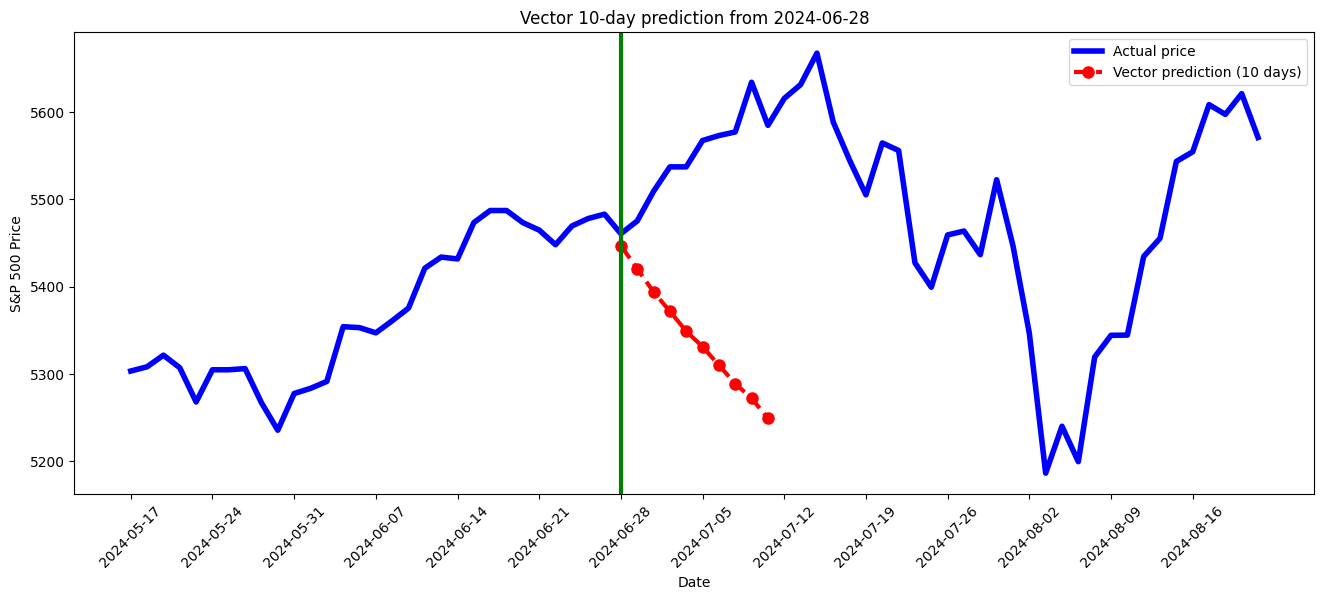

Mean Squared Error: 53056.0782
Root Mean Squared Error: 230.3391


In [38]:
plot_predictions2('2024-6-28')

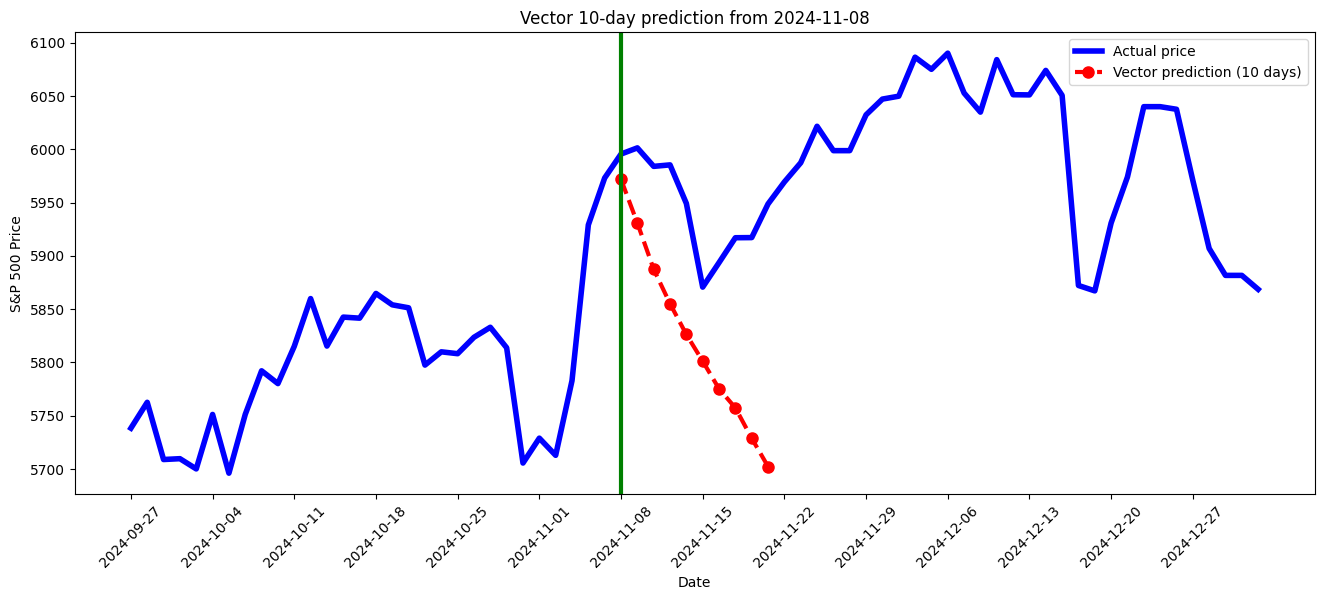

Mean Squared Error: 18766.4542
Root Mean Squared Error: 136.9907


In [39]:
plot_predictions2('2024-11-8')

7. Results Analysis
   - The result of "Idea 2" (which appears first in this notebook) accurately captures the broad movement of the 15 day predictive span.
   - Metrics that we used weren't really applicable, as we would have to make executive decisions about what days or predictions to actually plug into the metrics, and these would fail to represent our technique as a whole. Generally the graphs are the best indicator, and it indicates that our techniques are unpredictable and not very good.
   - The measure we tried to implement for each predictive events: MSE and RMSE doesn't accurately measure the accuracy of the model, since the absolute value of the price changes, and when the price is high, MSE goes up even if the prediction is more accurate.
   - For the future, we are looking into taking more historical data into our model, while keeping the number of features on the conservative side: coming up with a way to select which features are effective in the predictive model.
   - We would also like to try other types of models, such as neural networks, and maybe look at percent change instead of price as a whole. These might be better for our non-linear relationships, and the model should likely do a better job at predicting the variances.
   - Another point is expanding the type of indicators. There are numerous financial indicators specifically made for S&P price, so we want to explore those in the future.